# Pandas Examples

http://thinkstats2.com

Copyright 2017 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import nsfg
import first
import analytic

import thinkstats2

import seaborn

Let's read data from the BRFSS:

In [2]:
import brfss
df = brfss.ReadBrfss()

In [3]:
df.describe()

,age,sex,wtyrago,finalwt,wtkg2,htm3
count,410856.000000,414509.000000,390399.000000,414509.000000,398484.000000,409129.000000
mean,54.862180,1.624368,79.721319,561.774700,78.992453,168.825190
std,16.737702,0.484286,20.565164,1076.538764,19.546157,10.352653
min,18.000000,1.000000,22.727273,1.695143,20.000000,61.000000
25%,43.000000,1.000000,64.545455,97.006804,64.550000,160.000000
50%,55.000000,2.000000,77.272727,234.010543,77.270000,168.000000
75%,67.000000,2.000000,90.909091,590.775576,90.910000,175.000000
max,99.000000,2.000000,342.272727,60995.111700,309.090000,236.000000


If we group by sex, we get a `DataFrameGroupBy` object.

In [4]:
groupby = df.groupby('sex')
groupby

If we select a particular column from the `GroupBy`, we get a `SeriesGroupBy` object.

In [5]:
seriesgroupby = groupby.htm3
seriesgroupby

If you invoke a reduce method on a DataFrameGroupBy, you get a DataFrame:

In [6]:
groupby.mean()

,age,wtyrago,finalwt,wtkg2,htm3
sex,,,,,
1,54.114237,89.880639,727.426119,89.016966,178.066221
2,55.314401,73.278344,462.115407,72.684712,163.223475


If you invoke a reduce method on a SeriesGroupBy, you get a Series:

In [7]:
seriesgroupby.mean()

sex
1    178.066221
2    163.223475
Name: htm3, dtype: float64

You can use `aggregate` to apply a collection of reduce methods:

In [8]:
groupby.aggregate(['mean', 'std'])

age               wtyrago                finalwt               \
          mean        std       mean        std        mean          std   
sex                                                                        
1    54.114237  16.383712  89.880639  19.260805  727.426119  1370.544678   
2    55.314401  16.932158  73.278344  18.678964  462.115407   836.457063   

         wtkg2                   htm3            
          mean        std        mean       std  
sex                                              
1    89.016966  18.240528  178.066221  7.723563  
2    72.684712  17.609006  163.223475  7.269156

In [9]:
seriesgroupby.aggregate(['mean', 'std'])

,mean,std
sex,,
1,178.066221,7.723563
2,163.223475,7.269156


If the reduce method you want is not available, you can make your own:

In [10]:
def trimmed_mean(series):
    lower, upper = series.quantile([0.05, 0.95])
    return series.clip(lower, upper).mean()

Here's how it works when we apply it directly:

In [11]:
trimmed_mean(df.htm3)

168.65401132650092

And we can use `apply` to apply it to each group:

In [12]:
seriesgroupby.apply(trimmed_mean)

sex
1    178.109121
2    163.210210
Name: htm3, dtype: float64

## The digitize-groupby combo

Let's say we want to group people into deciles (bottom 10%, next 10%, and so on).

We can start by defining the cumulative probabilities that mark the borders between deciles.

In [13]:
ps = np.linspace(0, 1, 11)
ps

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

And then use `deciles` to find the values that correspond to those cumulative probabilities.

In [14]:
series = df.htm3
bins = series.quantile(ps)
bins

0.0     61.0
0.1    157.0
0.2    160.0
0.3    163.0
0.4    165.0
0.5    168.0
0.6    170.0
0.7    175.0
0.8    178.0
0.9    183.0
1.0    236.0
Name: htm3, dtype: float64

`digitize` takes a series and a sequence of bin boundaries, and computes the bin index for each element in the series.

In [15]:
np.digitize(series, bins)

array([2, 4, 5, ..., 9, 2, 9])

**Exercise:** Collect the code snippets from the previous cells to write a function called `digitize` that takes a Series and a number of bins and return the results from `np.digitize`.

In [16]:
def digitize(series, n=11):
    ps = np.linspace(0, 1, n)
    bins = series.quantile(ps)
    return np.digitize(series, bins)

Now, if your `digitize` function is working, we can assign the results to a new column in the DataFrame:

In [17]:
df['height_decile'] = digitize(df.htm3)
df.height_decile.describe()

count    414509.000000
mean          5.897512
std           2.924237
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          11.000000
Name: height_decile, dtype: float64

And then group by `height_decile`

In [18]:
groupby = df.groupby('height_decile')

Now we can compute means for each variable in each group:

In [19]:
groupby.mean()

,age,sex,wtyrago,finalwt,wtkg2,htm3
height_decile,,,,,,
1,59.343555,1.978576,65.732170,482.633403,65.071502,152.147807
2,57.708848,1.976869,68.925145,460.942597,68.415169,157.001891
3,56.693958,1.964062,71.014838,461.123901,70.420280,160.002595
4,55.411945,1.943195,72.962619,481.562164,72.417512,163.000728
5,55.010687,1.890204,74.834351,498.016131,74.251253,165.002383
6,54.469226,1.781678,77.115205,534.779185,76.563233,168.000509
7,53.708454,1.573876,80.716256,570.787161,80.072338,171.405279
8,53.354186,1.306171,85.399642,643.930094,84.663829,175.001213
9,53.838675,1.134095,89.774340,651.359825,88.932201,178.888785


It looks like:

1. The shortest people are older than the tallest people, on average.

2. The shortest people are much more likely to be female (no surprise there).

3. The shortest people are lighter than the tallest people (`wtkg2`), and they were lighter last year, too (`wtyrago`).

4. Shorter people are more oversampled, so they have lower final weights.  This is at least partly, and maybe entirely, due to the relationship with sex.

The fact that all of these variables are associates with height suggests that it will be important to control for age and sex for almost any analysis we want to do with this data.

Nevertheless, we'll start with a simple analysis looking at weights within each height group.

In [20]:
weights = groupby.wtkg2
weights

If we apply `quantile` to a `SeriesGroupBy`, we get back a `Series` with a `MultiIndex`.

In [21]:
quantiles = weights.quantile([0.25, 0.5, 0.75])
quantiles

height_decile      
1              0.25     54.55
               0.50     62.73
               0.75     72.73
2              0.25     57.73
               0.50     65.91
               0.75     76.36
3              0.25     59.09
               0.50     68.18
               0.75     78.64
4              0.25     61.36
               0.50     68.18
               0.75     81.36
5              0.25     63.18
               0.50     71.36
               0.75     81.82
6              0.25     64.09
               0.50     72.73
               0.75     84.09
7              0.25     68.18
               0.50     77.27
               0.75     88.64
8              0.25     72.73
               0.50     81.82
               0.75     90.91
9              0.25     77.27
               0.50     86.36
               0.75     97.27
10             0.25     84.09
               0.50     95.45
               0.75    106.82
11             0.25     59.09
               0.50     69.09
               0.75 

In [22]:
type(quantiles.index)

pandas.indexes.multi.MultiIndex

If you unstack a MultiIndex, the inner level of the MultIndex gets broken out into columns.

In [23]:
quantiles.unstack()

,0.25,0.5,0.75
height_decile,,,
1,54.55,62.73,72.73
2,57.73,65.91,76.36
3,59.09,68.18,78.64
4,61.36,68.18,81.36
5,63.18,71.36,81.82
6,64.09,72.73,84.09
7,68.18,77.27,88.64
8,72.73,81.82,90.91
9,77.27,86.36,97.27


Which makes it convenient to plot each of the columns as a line.

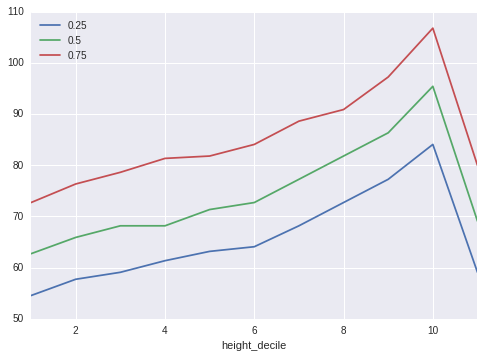

In [24]:
quantiles.unstack().plot()

The other view of this data we might like is the CDF of weight within each height group.

We can use `apply` with the `Cdf` constructor from `thinkstats2`.  The results is a Series of Cdf objects.

In [25]:
from thinkstats2 import Cdf

cdfs = weights.apply(Cdf)
cdfs

height_decile
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: wtkg2, dtype: object

And now we can plot the CDFs

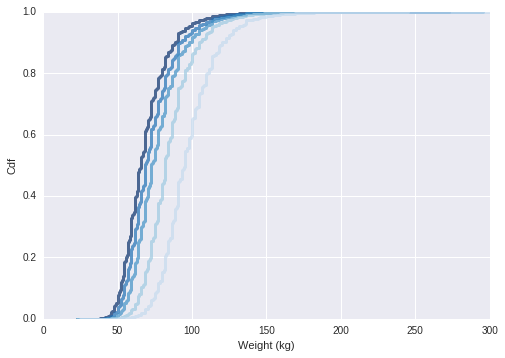

In [26]:
import thinkplot

thinkplot.Cdfs(cdfs[1:11:2])
thinkplot.Config(xlabel='Weight (kg)', ylabel='Cdf')

**Exercise:** Plot CDFs of weight for men and women separately, broken out by decile of height.

In [27]:
groupby = df.groupby(['sex', 'height_decile'])

In [28]:
groupby.mean()

age    wtyrago      finalwt      wtkg2        htm3
sex height_decile                                                          
1   1              53.844743  71.977922  1191.234678  71.514913  150.233293
    2              56.595658  71.746929  1003.079353  71.003320  157.025469
    3              54.869454  72.944564   964.772919  72.326525  160.028037
    4              56.042489  74.553472   879.420399  74.016273  163.005126
    5              55.165862  76.385110   917.796857  75.760722  165.013377
    6              56.300059  79.337985   814.286624  78.624502  168.001398
    7              56.170706  82.956049   705.872453  82.235605  171.753016
    8              55.213608  86.572882   706.591295  85.843598  175.001515
    9              54.734034  90.392173   676.266016  89.530755  178.925710
    10             51.677645  98.621484   721.615568  97.668112  186.240144
    11             50.650927  79.295724  1195.072324  78.971384  236.000000
2   1              59.464339  65.595065   467.120026  64.928121  152.189721
    2              57.735134  68.857631   448.105460  68.351735  157.001333
    3              56.762345  70.942543   442.349122  70.347362  160.001647
    4              55.373809  72.864145   457.600597  72.317857  163.000463
    5              54.991480  74.636768   446.241040  74.057330  165.001027
    6              53.955434  76.467033   456.712813  75.963038  168.000260
    7              51.872079  78.972655   470.481305  78.390760  171.147071
    8              49.126449  82.582291   501.930594  81.844168  175.000528
    9              48.030870  85.524509   490.531017  84.845692  178.650349
    10             47.388489  89.769177   526.098271  89.063530  185.475904
    11             56.722523  69.371896   664.090555  68.941935         NaN

In [29]:
groupby.wtkg2.mean()

sex  height_decile
1    1                71.514913
     2                71.003320
     3                72.326525
     4                74.016273
     5                75.760722
     6                78.624502
     7                82.235605
     8                85.843598
     9                89.530755
     10               97.668112
     11               78.971384
2    1                64.928121
     2                68.351735
     3                70.347362
     4                72.317857
     5                74.057330
     6                75.963038
     7                78.390760
     8                81.844168
     9                84.845692
     10               89.063530
     11               68.941935
Name: wtkg2, dtype: float64

In [30]:
cdfs = groupby.wtkg2.apply(Cdf)
cdfs

sex  height_decile
1    1                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     2                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     3                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     4                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     5                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     6                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     7                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     8                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     9                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     10               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     11               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    1                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     2                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
     3                [0.0, 0.0, 0.0, 0.0, 0.

In [31]:
cdfs.unstack()

height_decile,1,2,3,4,5,6,7,8,9,10,11
sex,,,,,,,,,,,
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [32]:
men = cdfs.unstack().loc[1]
men

height_decile
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 1, dtype: object

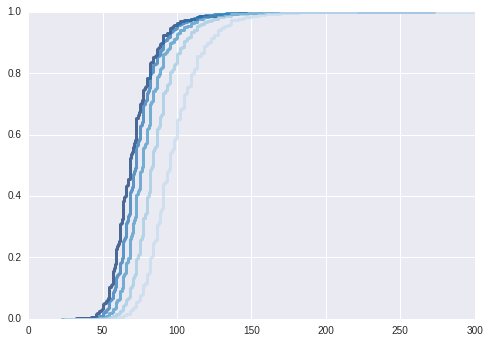

In [33]:
thinkplot.Cdfs(men[1:11:2])

In [34]:
women = cdfs.unstack().loc[2]
women

height_decile
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
8     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
10    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: 2, dtype: object

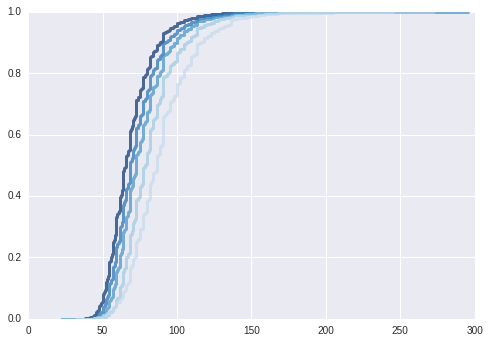

In [35]:
thinkplot.Cdfs(women[1:11:2])